# Model Creation: Round 2


#### Importing the necessary libraries

In [5]:
import library as lib
from library import Pipeline
import pitch_functions
from pitch_functions import run_classifier_models, roc_auc_score, calc_acc_and_f1_score

In [6]:
#DATA WRANGLING
import pandas as pd # Dataframes
from pandas.io.json import json_normalize # JSON wrangler
import statsapi # Python wrapper MLB data API

In [7]:
#DATA MANIPULATION AND MODELLING
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn_pandas import DataFrameMapper, FunctionTransformer, gen_features, pipeline
from sklearn_pandas.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import seaborn as sns
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
import xgboost as xgb
import os
import pitch_functions

In [8]:
lib.os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Load Data

In [103]:
each_pitch = lib.pd.read_csv('raw_data/cleaned_pitches.csv')

In [104]:
each_pitch2 = pd.read_csv('raw_data/cleaned_pitches1.csv')

## Final Model

In [105]:
pitch_clean = each_pitch.copy()

In [106]:
new_pitch = each_pitch2.copy()

In [107]:
pitch_clean = pitch_clean[:10000]

Create Binary Labels for Pitch Prediction: Fastball = 1 and Offspeed = 0.

In [108]:
pitch_dicts = {'Fastball': 1,
              'Breaking_Ball': 0,
              'Changeup': 0}

In [109]:
pitch_clean['pitch_type'] = pitch_clean['pitch_type'].map(pitch_dicts)

In [110]:
new_pitch['pitch_type'] = new_pitch['pitch_type'].map(pitch_dicts)

In [111]:
pitch_clean['prior_pitch_type'] = pitch_clean['prior_pitch_type'].map(pitch_dicts)

In [112]:
new_pitch['prior_pitch_type'] = new_pitch['prior_pitch_type'].map(pitch_dicts)

### Create target and predictor data frames

In [113]:
target = pitch_clean['pitch_type']

In [114]:
new_target = new_pitch['pitch_type']

In [149]:
predictors = pitch_clean.drop(['pitch_type', 'hitter', 'pitcher' ], axis=1)

In [150]:
new_preds = new_pitch.drop(['matchup.batter.fullName', 'matchup.pitcher.fullName', 'pitch_type', 'prior_pitch_type'], axis=1)

### Create categorical and numerical lists for the data pipeline. 

In [151]:
num_features = list(predictors.select_dtypes(exclude='object'))

In [152]:
new_n = list(new_preds.select_dtypes(exclude='object'))

In [153]:
num_features = [i for i in num_features if i not in {'about.inning', 'pitchData.zone', 'matchup.pitcher.id'}]

In [154]:
num_features1 = [i for i in new_n if i not in {'about.inning', 'pitchData.zone', 'matchup.pitcher.id', 'pitchData.nastyFactor', 'pitchData.zone'}]

In [155]:
cat_features = list(predictors.select_dtypes(include='object'))
cat_features.extend(['about.inning', 'pitchData.zone', 'count', 'matchup.pitcher.id'])

In [156]:
cat_features1 = list(new_preds.select_dtypes(include='object',))
cat_features1.extend(['about.inning', 'count', 'matchup.pitcher.id'])

### Create steps for data pipeline using cells above

In [157]:
numeric_transformer = Pipeline(steps=[('keeper', None)])

In [158]:
cat_transfomer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore', categories='auto'))])

In [159]:
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, num_features),
                                              ('cat', cat_transfomer, cat_features)])

In [160]:
preprocessor1 = ColumnTransformer(transformers=[('num', numeric_transformer, num_features1),
                                              ('cat', cat_transfomer, cat_features1)])

In [161]:
classifiers = [GradientBoostingClassifier(n_estimators=200, max_depth=10, learning_rate=.1), 
               xgb.XGBClassifier(n_estimators=200, max_depth=10, learning_rate=.1)]

In [190]:
new_preds.head(2)

,about.atBatIndex,about.halfInning,about.inning,details.call.description,details.description,matchup.batSide.code,matchup.pitchHand.code,matchup.pitcher.id,matchup.splits.menOnBase,pitchData.nastyFactor,pitchData.zone,pitchNumber,count
0,0,top,1,Hit Into Play - Out(s),"In play, out(s)",R,R,656302,Empty,NaN,NaN,1.0,0.0-0.0
1,1,top,1,Ball - Called,Ball,L,R,656302,Empty,NaN,NaN,1.0,1.0-0.0


In [181]:
last_pred = new_preds.drop(['pitchData.nastyFactor', 'pitchData.zone'], axis=1).copy()

In [182]:
last_pred = last_pred[-1:]

In [183]:
last_pred

,about.atBatIndex,about.halfInning,about.inning,details.call.description,details.description,matchup.batSide.code,matchup.pitchHand.code,matchup.pitcher.id,matchup.splits.menOnBase,pitchNumber,count
199,45,bottom,5,Strike - Swinging,Swinging Strike,R,L,596057,Empty,4.0,1.0-3.0


In [192]:
last_pred_pre = preprocessor1.fit(last_pred).transform(last_pred)

In [197]:
df = pd.DataFrame(last_pred_pre, columns=last_pred.columns)

ValueError: Shape of passed values is (12, 1), indices imply (11, 1)

## Model Creation

In [203]:
X_train, X_test, y_train, y_test = train_test_split(predictors, target, random_state=10)

In [46]:
X_train_pre = preprocessor.fit(X_train).transform(X_train)

In [59]:
X_test_pre = preprocessor.transform(X_test)


In [44]:
type(X_test_pre)

scipy.sparse.csr.csr_matrix

In [32]:
clf = GradientBoostingClassifier(n_estimators=200, max_depth=10)

In [48]:
clf.fit(X_train_pre.values.reshape(-1, 1), y_train)

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [41]:
clf.predict(X_test_pre)

ValueError: Number of features of the model must match the input. Model n_features is 153 and input n_features is 147 

## TO DO TOMORROW
- Use Model to Make Predictions on new data for Flask app
- Functionize this new method 
- Make slides
- Model is good

In [1]:
from pitch_functions import run_classifier_models

Using TensorFlow backend.


In [25]:
run_classifier_models(classifiers, preprocessor, X_train, X_test, y_train, y_test)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=10,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)


Training Metrics
Accuracy:1.000
F1-Score: 1.000
AUC: 1.000


Testing Metrics
Accuracy:0.796
F1-Score: 0.795
AUC: 0.784


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_

- Questions?
- How to set up functions
- Best practice on my notebook(ie - data cleaning)
- how to set this model up
- is pipeline a better way to go?

In [53]:
classifiers = GradientBoostingClassifier()

In [54]:
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', classifiers)])
pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None, steps=[('keeper', None)]), ['WAR_x', 'WHIP', 'ERA', 'SO', 'SLG', 'OPS', 'WAR_y', 'about.atBatIndex', 'pitchData.nasty...    subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))])

In [58]:
pipe.named_steps['classifier']

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [215]:
y_predss =pipe.predict(X_test)

In [213]:
y_preds = pitch_functions.calc_acc_and_f1_score(y_test, pipe.predict(X_test))

Accuracy:0.782
F1-Score: 0.779
AUC: 0.762


In [218]:
from sklearn.metrics import confusion_matrix, classification_report

In [228]:
cm = confusion_matrix(y_test, y_predss)

In [229]:
print(cm)

[[ 661  339]
 [ 205 1295]]


TypeError: show() got an unexpected keyword argument 'figsize'

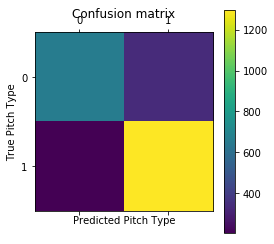

In [233]:
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True Pitch Type')
plt.xlabel('Predicted Pitch Type')
plt.show(figsize=(20,20))
plt.savefig('confusion matrix')

In [ ]:
confusion_matrix()